### **Spacecraft_MRP_PD** 
本项目使用 PD 控制器对简单航天器进行重定向  
本项目的工作是：
1. 使用 **MRP** 代替四元数作为航天器动力学模型，模型存在model文件中
2. 将控制量 Tr 作为参数传入航天器的动力学再进行积分，而不是预先写在航天器的动力学里  
这样的好处是可以分离控制器和动力学，将控制器用不同的方式进行实现，为后面引入**强化学习**做准备
3. 在求解IVP的时候，因为控制器需要实时根据航天器的状态进行计算，所以采用一个循环离散化地计算每个小时间步长的积分值

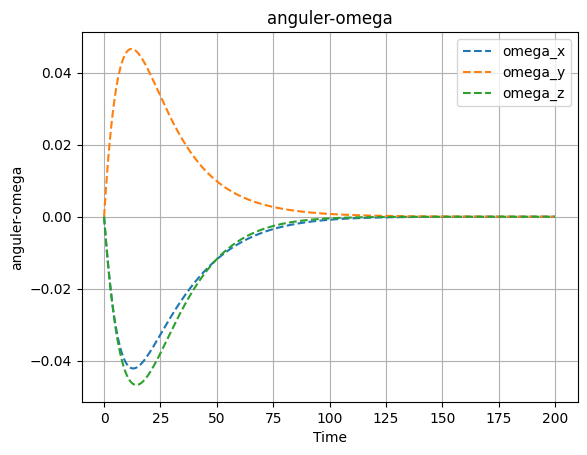

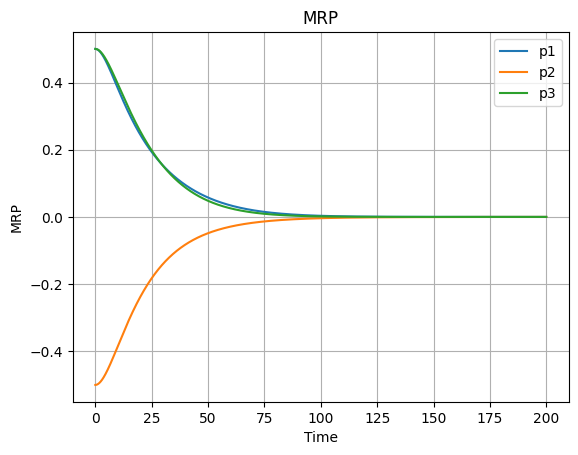

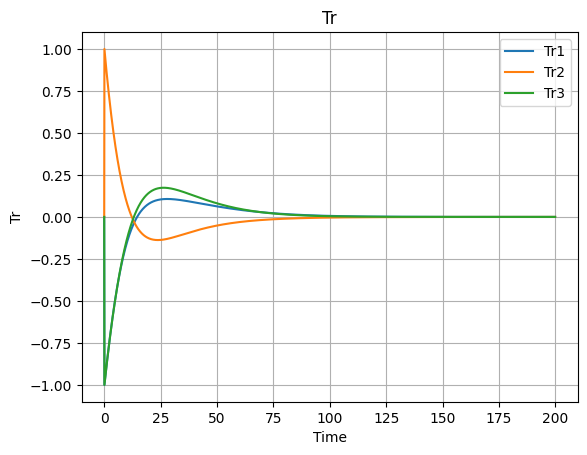

In [8]:
from model import spacecraft_simplified
import numpy as np
from scipy.integrate import solve_ivp
from spacecraft_env import SpacecraftEnv, plot_omega, plot_p, plot_Tr

J = np.array([[120, 0, 0],
              [0, 100, 0],
              [0, 0, 120]])

sat1 = spacecraft_simplified(J)


#计算步数
n = 2000
time_prev = 0
deltat = 0.1    #每隔deltat时间   计算一次控制量 Tr,  积分deltat时间
Kp = 2
Kd = 15

#给初值
X_sol = np.array([[0],[0],[0], [0.5],[-0.5],[0.5]])  # 前三个对应omega，后三个对应MRP数
t_sol = np.array([time_prev])
Tr_sol = np.array([[0],[0],[0]])


for i in range(1, n):
    X_prev = X_sol[:,-1]
    omega = X_prev[:3]
    p = X_prev[3:6]

    time = i * deltat
    tspan = np.linspace(time_prev,time,100) # 每个deltat时间划分为1000个步长来积分
    tspanivp = (tspan[0], tspan[-1])

    Tr = -Kp * p - Kd * omega  # 控制器           
    
    sol = solve_ivp(fun=lambda t, X: sat1.dynamics(t, X, Tr),
                     t_span=tspanivp,
                     y0=X_sol[:,-1],
                     t_eval=tspan,
                     method='LSODA')
    #print(sol)
    t_sol = np.append(t_sol, time)
    X_sol = np.column_stack((X_sol, sol.y[:,-1]))
    Tr_sol = np.column_stack((Tr_sol, Tr))
    time_prev = time

plot_omega(t_sol, X_sol)
plot_p(t_sol, X_sol)
plot_Tr(t_sol, Tr_sol)


结果与之前将PD控制器写入动力学的效果几乎相同，验证可行性